# Test

In [1]:
# for i in range(objectNum):
#     print (objectsTime[i][0], objectsTime[i][1], objectsTime[i][2])

# N = int(objectsTime[0][2]/dtObject)
# endTime = objectsTime[0][0] + (N - 1)*dtObject
# groundtruth = np.linspace (objectsTime[0][0], endTime, N)
# print ("groundtruth - length:", len (groundtruth), ", start time:", groundtruth[0], ", end time:", groundtruth[-1])

# print (objectsTime[0][2])

In [2]:
# for i in range (objectNum):
#     N = int(objects[i].intervalTime/dtObject)
#     endTime = objects[i].startTime + (N - 1)*dtObject
#     objectInfo = np.linspace (objects[i].startTime, endTime, N)
#     print ("object - length:", len (objectInfo), ", start time:", objectInfo[0], ", end time:", objectInfo[-1])

In [3]:
# for i in range (objectNum):
#     measurementNumber = int(objects[i].intervalTime/dtRadar)
#     endTime = objects[i].startTime + (measurementNumber - 1)*dtRadar

#     timesRadar_test = np.linspace (objects[i].startTime, endTime, measurementNumber)

#     print ("timesRadar_test - length:", len (timesRadar_test), ", start time:", timesRadar_test[0], ", end time:", timesRadar_test[-1])

# 1. Ground truth

## Import

* import numpy for matrix
* import matplotlib.pyplot for plotting
* import math for math function
* import random for random variable. Creating noise or start point etc

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import math
import random
import copy

## Init constant value and other functions

* Init object number
* Create object which life time is random
* object ground truth dt is 5 ms  


* Lidar detecting dt is 25 ms
* Radar detecting dt is 50 ms

In [5]:
objectNum = 5

# time const
startTime_Sec = 0.0
endTime_Sec = 20.0

objectsTime = []

dtObject = 0.005 # 5ms
dtLidar = 0.025 # 25ms
dtRadar = 0.050 # 50ms
dtTracking = 0.01 # 10ms

# create objects time
for _ in range(objectNum):
    startTime = random.uniform(startTime_Sec, endTime_Sec)
    
    endTime = 0.0
    while (endTime < (startTime)):
        endTime = random.uniform(startTime_Sec, endTime_Sec)
        
    intervalTime = endTime - startTime
    
    objectsTime.append([startTime, endTime, intervalTime])


# plot type
TRAJECTORY = 1
X = 2
Y = 3


# noise size
LidarNoiseSize = 2
RadarNoiseSize = 2 # 0 < RadarNoiseSize < 1000


# convenient function and class
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

class Trajectory():
    def __init__ (self):
        self.x = []
        self.y = []
        self.rho = []
        self.phi = []
        
# model
CV = 0
CA = 1

# measurement type
LIDAR = 0
RADAR = 1

### [matplotlib color](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.plot.html)

The supported color abbreviations are the single letter codes

|character|color
|:-------:|:-------:
|'b'      |blue
|'g'      |green
|'r'      |red
|'c'      |cyan
|'m'      |magenta
|'y'      |yellow
|'k'      |black
|'w'      |white

### [python dictionary](https://wikidocs.net/16043)

* 딕셔너리 타입은 immutable한 키(key)와 mutable한 값(value)으로 맵핑되어 있는 순서가 없는 집합
* 일반적인 딕셔너리 타입의 모습, 중괄호로 되어 있고 키와 값

```python
>>> {"a" : 1, "b":2}
{'a': 1, 'b': 2}
```

* 순서가 없기 때문에 인덱스로는 접근할수 없고, 키로 접근 할 수 있음

```python
>>> d = {'abc' : 1, 'def' : 2}
>>> d[0]
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyError: 0
>>> d['abc']
1
```

In [6]:
# color define
COLOR = {'blue' : 'b',
         'green' : 'g',
         'red' : 'r',
         'cyan' : 'c',
         'magenta' : 'm',
         'yellow' : 'y',
         'black' : 'k',
         'white' : 'w'}

## Object model

* Const accelerate model

$x' = Ax + Bu$

<img src="./img/ConstantVelocitySystemModel.png" width="50%" height="50%">

* Const velocity model

In [7]:
class Object():
    def __init__ (self, times, x, y, ID, model):
        self.ID = ID
        self.states = []
        self.trajectory = Trajectory()
        self.model = model
        
        self.times = times
        self.startTime = times[0]
        self.endTime = times[-1]
        self.intervalTime = self.endTime - self.startTime
        
        self.isDetected = False
        
        # state: x, y, x`, y`, x``, y``
        self.state_ca = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T
        
        # state: x, y, x`, y`
        self.state_cv = np.matrix([0.0, 0.0, 0.0, 0.0]).T
        
        # state: x, y, x`, y`, x``, y``
        self.state_ca[0] = x
        self.state_ca[1] = y
        
        # state: x, y, x`, y`
        self.state_cv[0] = x
        self.state_cv[1] = y
        
        # select model
        if self.model == CV:
            self.F = np.matrix([[1.0, 0.0, dtObject, 0.0],
                             [0.0, 1.0, 0.0, dtObject],
                             [0.0, 0.0, 1.0, 0.0],
                             [0.0, 0.0, 0.0, 1.0]])

            self.B = np.matrix([[0.0, 0.0],
                               [0.0, 0.0],
                               [1.0, 0.0],
                               [0.0, 1.0]])
            
        elif self.model == CA:
            self.F = np.matrix([[1.0, 0.0, dtObject, 0.0, 1/2.0*dtObject**2, 0.0],
                             [0.0, 1.0, 0.0, dtObject, 0.0, 1/2.0*dtObject**2],
                             [0.0, 0.0, 1.0, 0.0, dtObject, 0.0],
                             [0.0, 0.0, 0.0, 1.0, 0.0, dtObject],
                             [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

            self.B = np.matrix([[0.0, 0.0],
                               [0.0, 0.0],
                               [0.0, 0.0],
                               [0.0, 0.0],
                               [1.0, 0.0],
                               [0.0, 1.0]])
    
    def getState(self, u):
        if self.model == CV:
            self.state_cv = self.F*self.state_cv + self.B*u
            return self.state_cv
        
        elif self.model == CA:
            self.state_ca = self.F*self.state_ca + self.B*u
            return self.state_ca
        
    def getStatus(self, time, dt):
        prevTime = time - dt
        nextTime = time + dt
        
        if (self.startTime > prevTime) and (self.startTime < nextTime):
            self.isDetected = True
        
        
    def subplots(self, axes, ID, color):
        
        axes[0].plot (self.trajectory.x, self.trajectory.y, color=color, label='Ground truth{0}'.format(ID))
        axes[1].plot (self.times, self.trajectory.x, color=color, label='Ground truth{0}'.format(ID))
        axes[1].set_xlim ([startTime_Sec, endTime_Sec])

        axes[2].plot (self.times, self.trajectory.y, color=color, label='Ground truth{0}'.format(ID))
        axes[2].set_xlim ([startTime_Sec, endTime_Sec])
        
        
    def plot (self, ID, pltType, color):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, color=color, linewidth=1.5, linestyle="-",label="Ground truth {0}".format(ID))
                
        elif pltType == X:
            plt.plot(self.times, self.trajectory.x, color=color, linewidth=1.5, linestyle="-",label="Ground truth {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(self.times, self.trajectory.y, color=color, linewidth=1.5, linestyle="-",label="Ground truth {0}".format(ID))

## Object simulation

whole system's start time = 0
whole system's end time = 10

In [8]:
objects = []

# create object with random position
for objectIdx in range(objectNum):
    measurementNumber = int(objectsTime[objectIdx][2]/dtObject)
    endTime = objectsTime[objectIdx][0] + (measurementNumber - 1)*dtObject
    objectsTimes = np.linspace (objectsTime[objectIdx][0], endTime, measurementNumber)
    
    x = random.uniform(0.0, 1000.0)
    y = random.uniform(0.0, 1000.0)
    
    object = Object(objectsTimes, x, y, objectIdx, CV)
    objects.append(object)


# get object state
for objectIdx, object in enumerate(objects):
    for t in range(len(object.times)):
    
        if (t % 5) == 0:
            if object.model == CV:
                vel = random.uniform(-10.0, 10.0)
                radian = random.uniform(-math.pi, math.pi)

                u = np.matrix([vel*math.cos(radian), vel*math.sin(radian)]).T
                
            if object.model == CA:
                accel = random.uniform(-10.0, 10.0)
                radian = random.uniform(-math.pi, math.pi)

                u = np.matrix([accel*math.cos(radian), accel*math.sin(radian)]).T
        
        state = object.getState(u)

        object.states.append(state)
        object.trajectory.x.append (state[0, 0])
        object.trajectory.y.append (state[1, 0])

## Plotting object trajectory and x, y

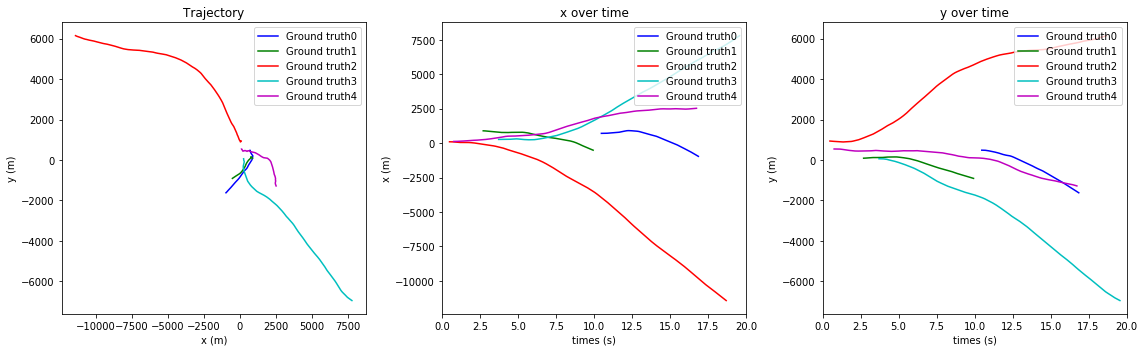

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (16, 5))
colors = list(COLOR.values())

for objectIdx, object in enumerate (objects):
    object.subplots (axes, objectIdx, colors[objectIdx])
    
    axes[0].legend(loc="upper right")
    axes[0].set(xlabel = 'x (m)', ylabel = 'y (m)')
    axes[0].set_title('Trajectory')
    
    axes[1].legend(loc="upper right")
    axes[1].set(xlabel = 'times (s)', ylabel = 'x (m)')
    axes[1].set_title('x over time')
    
    axes[2].legend(loc="upper right")
    axes[2].set(xlabel = 'times (s)', ylabel = 'y (m)')
    axes[2].set_title('y over time')

    plt.tight_layout()

# 2. Sensor model

Lidar dt: 25 ms  
Radar dt: 50 ms

### 2.1 Lidar model

In [13]:
class LiDAR():
    def __init__(self, times):
        self.times = times
        self.measurements = []
        self.trajectory = Trajectory()

        
    def measure (self, state):
        if len (state) == 6:
            H = np.matrix ([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
        else:
            H = np.matrix ([[1.0, 0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0, 0.0]])
        
        measurement = H*state

        # Noise
        sensor_noise = np.random.randn()*LidarNoiseSize
        measurement[0, 0] = measurement[0, 0] + sensor_noise

        sensor_noise = np.random.randn()*LidarNoiseSize
        measurement[1, 0] = measurement[1, 0] + sensor_noise

        self.measurements.append (measurement)
        self.trajectory.x.append (measurement[0, 0])
        self.trajectory.y.append (measurement[1, 0])

                
    def subplots(self, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, 'b.', markersize=4, label='Lidar{0}'.format(ID))
        axes[1].plot (self.times, self.trajectory.x, 'b.', markersize=4, label='Lidar{0}'.format(ID))
        axes[2].plot (self.times, self.trajectory.y, 'b.', markersize=4, label='Lidar{0}'.format(ID))
    
    
    def plot (self, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, 'bo', markersize=4, label="Lidar {0}".format(ID))
                
        elif pltType == X:
            plt.plot(self.times, self.trajectory.x, 'bo', markersize=4, label="Lidar {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(self.times, self.trajectory.y, 'bo', markersize=4, label="Lidar {0}".format(ID))

### 2.2 Radar model

Radar is no __H__ matrix that will map the state vector __x__ into polar coordinates. Instead, you need to calculate the mapping manually to convert from cartesian coordinates to polar coordinates.

Here is the __h__ function that specifies how the predicted position and speed get mapped to the polar coordinates of range, bearing and range rate.

![Img](./img/RadarSystemModeling.PNG)

In [14]:
class Radar():
    def __init__ (self, times):
        self.times = times
        self.measurements = []
        self.trajectory = Trajectory()

    def measure(self, state):
        measurement = np.matrix([0.0, 0.0, 0.0]).T  

        px = state[0, 0]
        py = state[1, 0]
        vx = state[2, 0]
        vy = state[3, 0]

        rho = math.sqrt(px**2 + py**2)
        phi = math.atan2(py, px)

        if rho < 0.0001:
            rho = 0.0001
        rhoDot = (px*vx + py*vy)/rho

        # noise
        sensorNoise = np.random.randn() * math.pi * (RadarNoiseSize/1000)
        phi = phi + sensorNoise

        measurement[0, 0] = rho
        measurement[1, 0] = phi
        measurement[2, 0] = rhoDot

        self.measurements.append(measurement)
        self.trajectory.rho.append (rho)
        self.trajectory.phi.append (phi)
        x, y = pol2cart(rho, phi)
        self.trajectory.x.append (x)
        self.trajectory.y.append (y)

                
    def subplots(self, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, 'g.', markersize=4, label='Radar{0}'.format(ID))
        axes[1].plot (self.times, self.trajectory.x, 'g.', markersize=4, label='Radar{0}'.format(ID))
        axes[2].plot (self.times, self.trajectory.y, 'g.', markersize=4, label='Radar{0}'.format(ID))
    
    
    def plot (self, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, 'go', markersize=4, label="Radar {0}".format(ID))
            
        elif pltType == X:
            plt.plot(self.times, self.trajectory.x, 'go', markersize=4, label="Radar {0}".format(ID))   
        elif pltType == Y:
            plt.plot(self.times, self.trajectory.y, 'go', markersize=4, label="Radar {0}".format(ID))

## Generate LiDAR measurement and Radar measurement

In [15]:
lidars = []
radars = []

for object in objects:
    
    # Generate Lidar measurement
    measurementNumber = int (object.intervalTime/dtLidar)
    endTime = object.startTime + (measurementNumber - 1)*dtLidar
    timesLidar = np.linspace (object.startTime, endTime, measurementNumber)
    
    lidar = LiDAR(timesLidar)
    
    LidarMeasIdx = 0
    for t_Idx, t in enumerate (object.times):
        minTime = t - 0.000001
        maxTime = t + 0.000001
        
        if ((lidar.times[LidarMeasIdx] > minTime) and (lidar.times[LidarMeasIdx] < maxTime)):
            lidar.measure(object.states[t_Idx])
            LidarMeasIdx = LidarMeasIdx + 1
            
            if (LidarMeasIdx == len (lidar.times)):
                break
    lidars.append(lidar)

    # Generate Radar measurement
    measurementNumber = int (object.intervalTime/dtRadar)
    endTime = object.startTime + (measurementNumber - 1)*dtRadar
    timesRadar = np.linspace (object.startTime, endTime, measurementNumber)
    
    radar = Radar(timesRadar)

    RadarMeasIdx = 0
    for t_Idx, t in enumerate (object.times):
        minTime = t - 0.000001
        maxTime = t + 0.000001
        
        if ((radar.times[RadarMeasIdx] > minTime) and (radar.times[RadarMeasIdx] < maxTime)):
            radar.measure(object.states[t_Idx])
            RadarMeasIdx = RadarMeasIdx + 1
            
            if (RadarMeasIdx == len (radar.times)):
                break
    radars.append(radar)

## Comparison ground truth with LiDAR

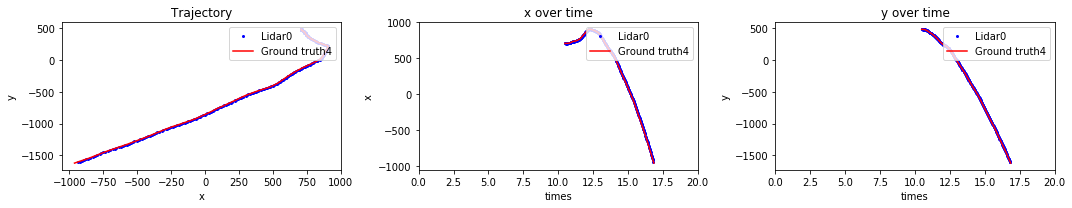

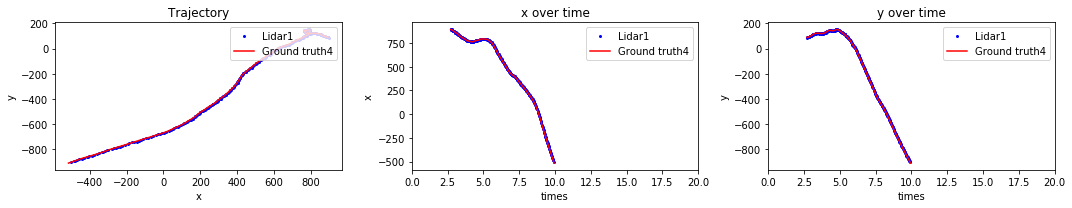

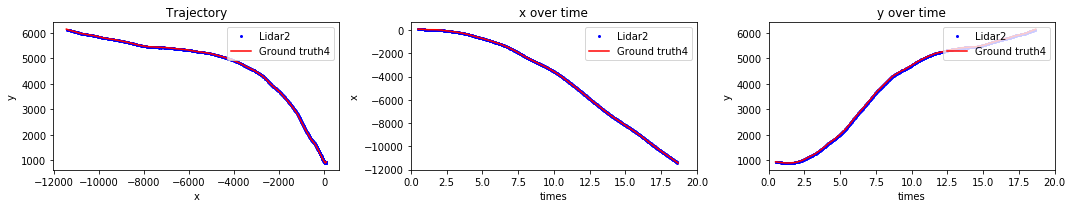

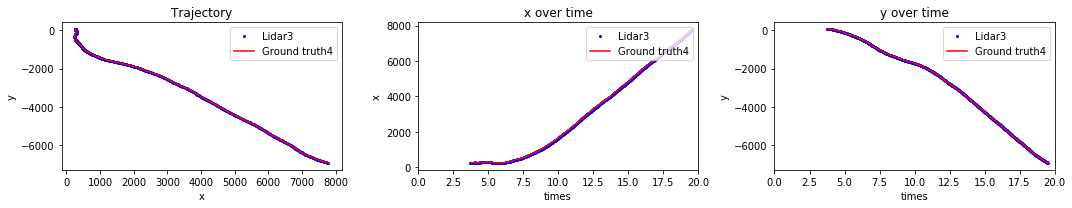

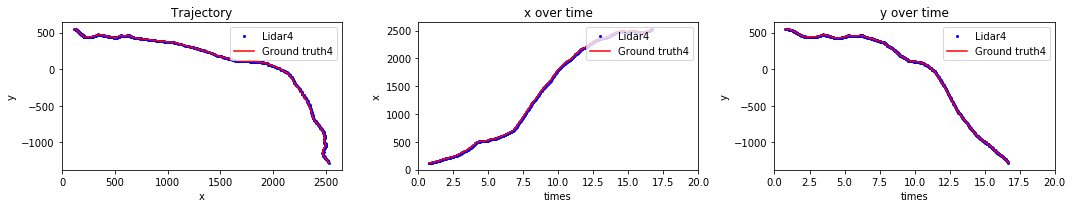

In [17]:
for Idx, lidar in enumerate(lidars):
    fig, axes = plt.subplots(1, 3, figsize = (15,3))
    lidar.subplots(axes, Idx)
    objects[Idx].subplots (axes, objectIdx, COLOR['red'])
    
    axes[0].legend(loc="upper right")
    axes[0].set(xlabel = 'x', ylabel = 'y')
    axes[0].set_title('Trajectory')

    axes[1].legend(loc="upper right")
    axes[1].set(xlabel = 'times', ylabel = 'x')
    axes[1].set_title('x over time')

    axes[2].legend(loc="upper right")
    axes[2].set(xlabel = 'times', ylabel = 'y')
    axes[2].set_title('y over time')
    
    plt.tight_layout()
    plt.show()

Input lidar number: 
0


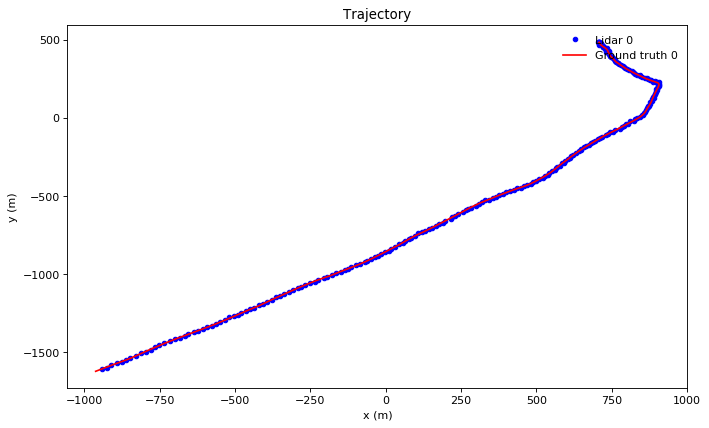

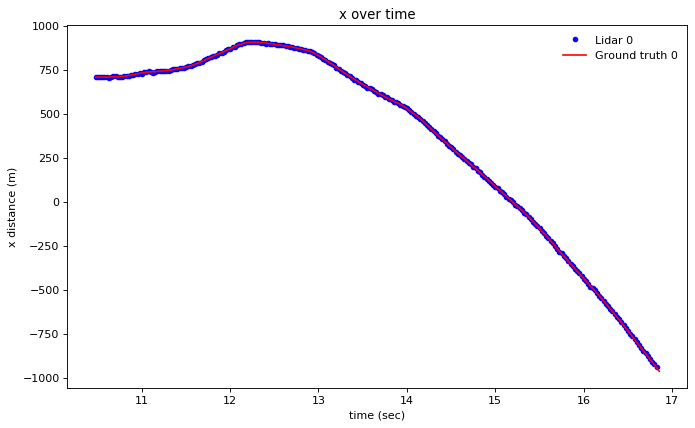

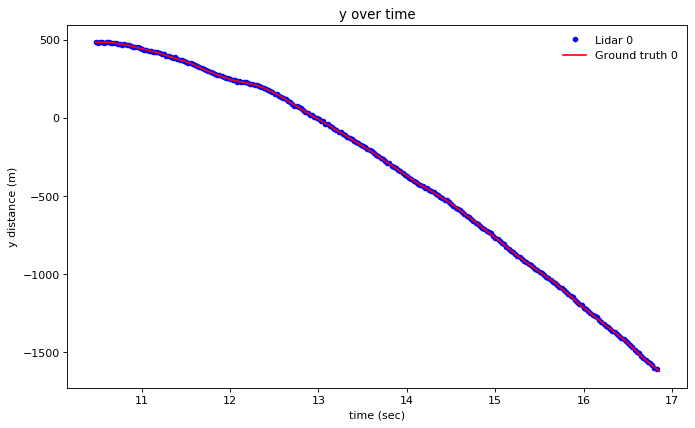

In [19]:
print ("Input lidar number: ")
obj = int(input())

# Trajectory
plt.figure(figsize=(10,6), dpi=80)
plt.title("Trajectory")
lidars[obj].plot (obj, TRAJECTORY)
objects[obj].plot (obj, TRAJECTORY, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
lidars[obj].plot (obj, X)
objects[obj].plot (obj, X, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
lidars[obj].plot (obj, Y)
objects[obj].plot (obj, Y, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()

## Comparison ground truth with Radar

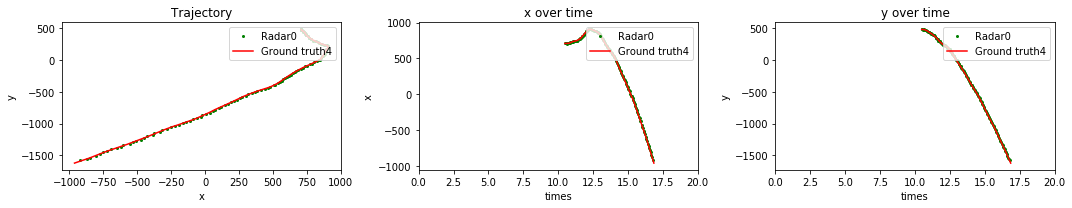

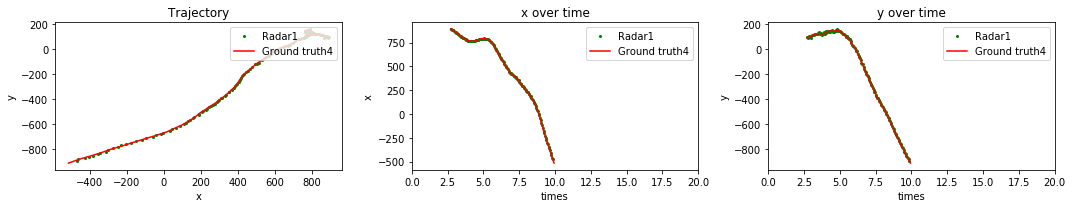

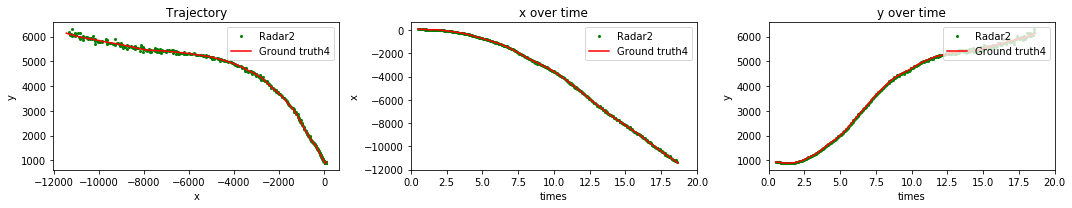

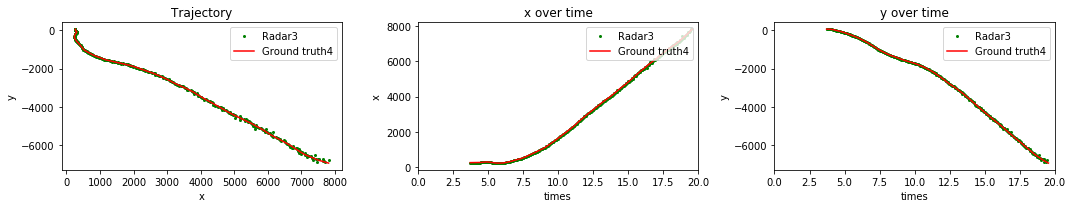

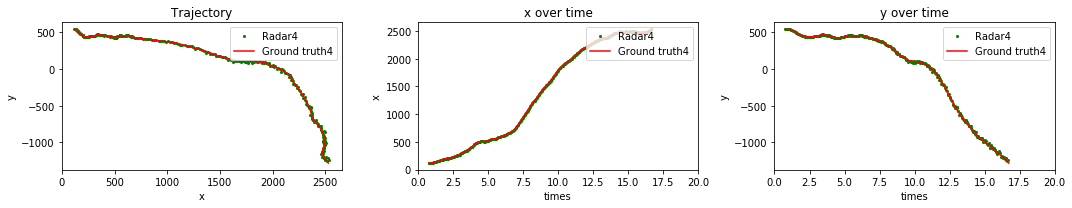

In [20]:
for Idx, radar in enumerate(radars):
    fig, axes = plt.subplots(1, 3, figsize = (15,3))
    radar.subplots(axes, Idx)
    objects[Idx].subplots (axes, objectIdx, COLOR['red'])
    
    axes[0].legend(loc="upper right")
    axes[0].set(xlabel = 'x', ylabel = 'y')
    axes[0].set_title('Trajectory')

    axes[1].legend(loc="upper right")
    axes[1].set(xlabel = 'times', ylabel = 'x')
    axes[1].set_title('x over time')

    axes[2].legend(loc="upper right")
    axes[2].set(xlabel = 'times', ylabel = 'y')
    axes[2].set_title('y over time')
    
    plt.tight_layout()
    plt.show()

Input radar number: 
0


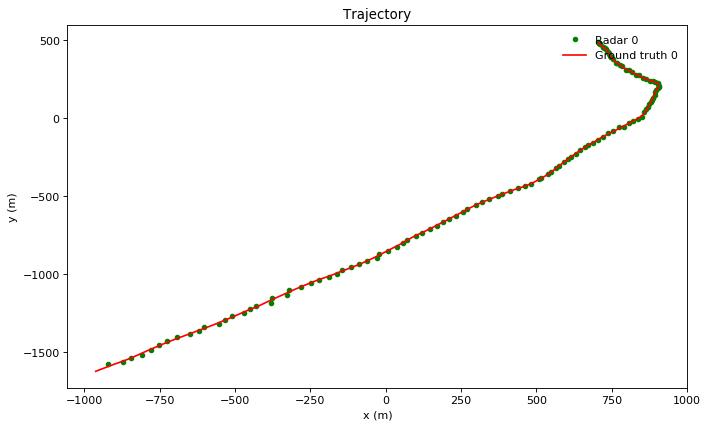

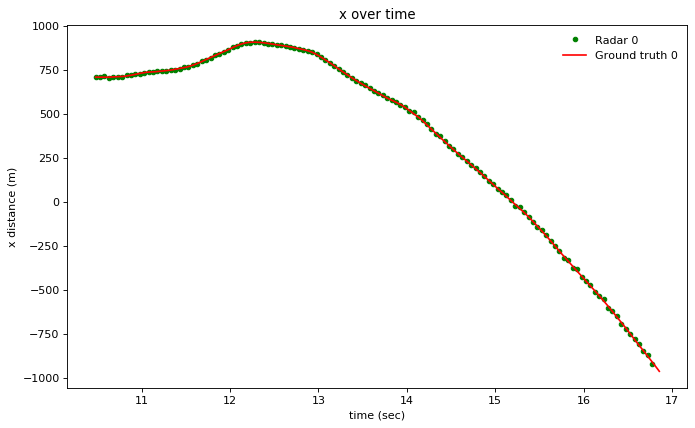

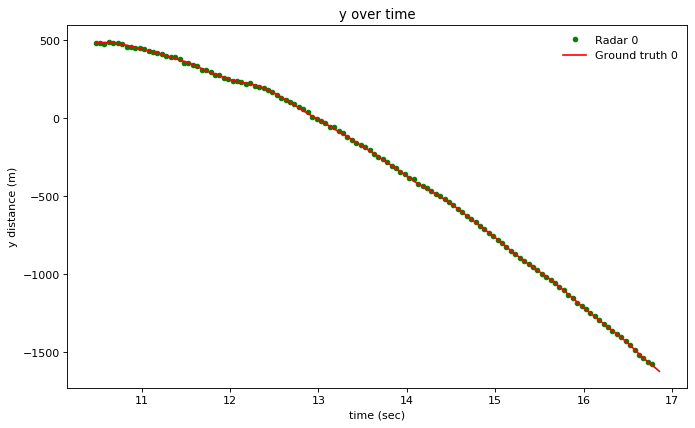

In [21]:
print ("Input radar number: ")
obj = int(input())

# Trajectory
plt.figure(figsize=(10,6), dpi=80)
plt.title("Trajectory")
radars[obj].plot (obj, TRAJECTORY)
objects[obj].plot (obj, TRAJECTORY, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
radars[obj].plot (obj, X)
objects[obj].plot (obj, X, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
radars[obj].plot (obj, Y)
objects[obj].plot (obj, Y, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()

## Comparison of ground truth with measurement

Input measurement number: 
0


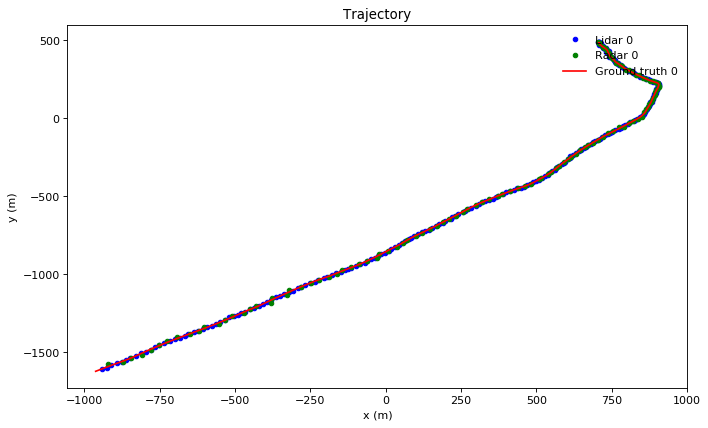

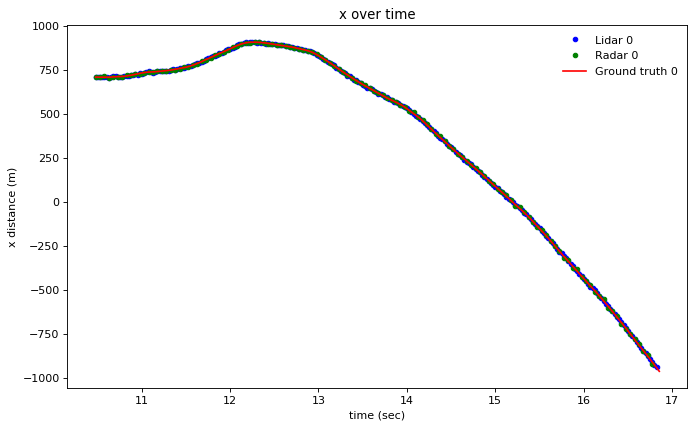

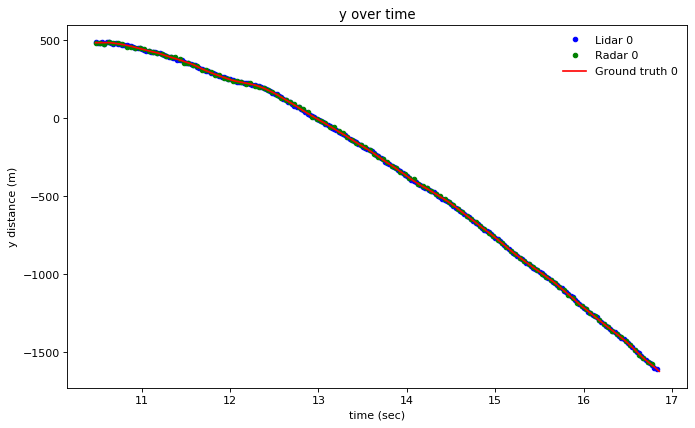

In [23]:
print ("Input measurement number: ")
obj = int(input())

# Trajectory
plt.figure(figsize=(10,6), dpi=80)
plt.title("Trajectory")
lidars[obj].plot (obj, TRAJECTORY)
radars[obj].plot (obj, TRAJECTORY)
objects[obj].plot (obj, TRAJECTORY, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
lidars[obj].plot (obj, X)
radars[obj].plot (obj, X)
objects[obj].plot (obj, X, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
lidars[obj].plot (obj, Y)
radars[obj].plot (obj, Y)
objects[obj].plot (obj, Y, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()

# 3. Tracking 

dt = 10 ms

### Mapping predicted state into Radar measurement

Radar Measurements lecture that the __h__ function is composed of three equations that show how the predcited state, $x' = (p'_x, p'_y, v'_x, v'_y)^T$, is mapped into the measurement space, $z = (\rho, \phi, \dot{\rho})^T$

![Img](./img/RadarSystemModeling.PNG)

In [15]:
def h (state):
    px = state[0, 0]
    py = state[1, 0]
    vx = state[2, 0]
    vy = state[3, 0]

    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    rhoRate = (px*vx + py*vy)/rho
    
    x = np.matrix([rho, phi, rhoRate]).T
    
    return x

### [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant#Jacobian_matrix)

* Jacobian matrix 

The Jacobian of a [vector-valued function](https://math.boisestate.edu/~jaimos/classes/m275-fall2017/notes/vector-fcn1.html) in several variables generalizes the gradient of a [scalar-valued function](http://web.mit.edu/wwmath/vectorc/scalar/intro.html) in several variables, which in turn generalizes the derivative of a scalar-valued function of a single variable. In other words, the Jacobian matrix of a scalar-valued function in several variables is (the transpose of) its gradient and the gradient of a scalar-valued function of a single variable is its derivative.

* Critical points

If $f : ℝ^n → ℝ^m$ is a differentiable function, a critical point of __f__ is a point where the rank of the Jacobian matrix is not maximal. This means that the rank at the critical point is lower than the rank at some neighbour point. In other words, let _k_ be the maximal dimension of the open balls contained in the image of __f__; then a point is critical if all minors of rank _k_ of __f__ are zero.

* __Examples1__

Consider the function $f : ℝ^2 → ℝ^2$, with $(x, y) ↦ (f1(x, y), f2(x, y))$, given by

![Img](./img/JacobianExample1-1.PNG)

Then we have $f_1(x, y) = x^2y$ and $f_2(x, y) = 5x + siny$ and the Jacobian matrix of __f__ is

![Img](./img/JacobianExample1-2.PNG)

and the Jacobian determinant is $det(J_f(x, y)) = 2xycosy - 5x^2$

* __Examples2:__ spherical-Cartesian trasnformation

The transformation form spherical coordinates $(r, \theta, \phi)$ to Cartesian coordinates $(x, y, z)$, is given by the function $F: ℝ^+× [0, π] × [0, 2 π) → ℝ^3$ with components:

$x = rsin(\theta)cos(\phi);$  
$y = rsin(\theta)sin(\phi);$  
$z = rcos(\theta)$

The jacobian matrix for this coordinate change is

![Img](./img/JacobianExample2-1.PNG)

The determinant is $r^2 sin\theta$. As an example, since $dV = dx dy dz$ this determinant implies that the differential volume elemnet $dV = r^2 sin\theta drd\theta d\phi $. Unlike for a change of Cartesian coordinates, this determinant is not a constant, and varies with coordinates $(r and \theta)$

* __Examples3:__ Multivariate Taylor Series with a one-dimensional equation

__h__ function is composed by multi-dimensional equations, so we will need to use a multi-dimensional Taylor series expansion to make a linear approximation of the __h__ function. Here is a general formula for the multi-dimensional Taylor series expansion

![Img](./img/multi-dimensional_Taylor_series_expansion.PNG)

$Df(a)$ is called the __Jacobian matrix__ and $D^2f(a)$ is called the [__Hessian matrix__](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian). To derive a linear approximation for the h function, we will only keep the expansion up to the Jacobian matrix $Df(a)$.

![Img](./img/Jacobian_H_j_matrix.PNG)

![Img](./img/Jacobian_H_j_matrix_result.PNG)

you have to check that neither x nor y is zero." What is meant is: "you have to check that x and y are not both zero

In [16]:
def calculateJacobian (state, Hj):
    
    px = state[0, 0]; py = state[1, 0]
    vx = state[2, 0]; vy = state[3, 0]
    
    if len(state) == 6:
        ax = state[4, 0]; ay = state[5, 0]
    
    c1 = px**2 + py**2
    c2 = math.sqrt(c1)
    c3 = c1*c2
    
    
    if math.fabs(c1) < 0.0001:
        print ("c1 < 0.0001")
        return Hj
    
    rhoDpx = px/c2
    rhoDpy = py/c2
    rhoDvx = 0; rhoDvy = 0
    if len(state) == 6:
        rhoDax = 0; rhoDay = 0
    
    phiDpx = -py/c1
    phiDpy = px/c1
    phiDvx = 0; phiDvy = 0
    if len(state) == 6:
        phiDax = 0; phiDay = 0
    
    rhoDotDpx = py*(vx*py - vy*px)/c3
    rhoDotDpy = px*(vy*px - vx*py)/c3
    rhoDotDvx = px/c2
    rhoDotDvy = py/c2
    if len(state) == 6:
        rhoDotDax = 0; rhoDotDay = 0
    
    if len(state) == 6:
        Hj = np.matrix([[rhoDpx, rhoDpy, rhoDvx, rhoDvy, rhoDax, rhoDay],
                      [phiDpx, phiDpy, phiDvx, phiDvy, phiDax, phiDay],
                      [rhoDotDpx, rhoDotDpy, rhoDotDvx, rhoDotDvy, rhoDotDax, rhoDotDay]])
    
    else:
        Hj = np.matrix([[rhoDpx, rhoDpy, rhoDvx, rhoDvy],
                      [phiDpx, phiDpy, phiDvx, phiDvy],
                      [rhoDotDpx, rhoDotDpy, rhoDotDvx, rhoDotDvy]])
    return Hj

## Kalman Filter

In [36]:
class KalmanFilter():
    def __init__(self, model, measureType):
        
        self.model = model
        self.measureType = measureType
        self.varState = 150.0
        self.varMeas = 10.0
        
        if self.model == CV:
            self.x = np.matrix([0.0, 0.0, 0.0, 0.0]).T

            if self.measureType == LIDAR:
                self.P = np.matrix([[1.0, 0.0, 0.0, 0.0],
                                 [0.0, 1.0, 0.0, 0.0],
                                 [0.0, 0.0, 1000.0, 0.0],
                                 [0.0, 0.0, 0.0, 1000.0]])
            
            elif self.measureType == RADAR:
                self.P = np.matrix([[1.0, 0.0, 0.0, 0.0],
                                 [0.0, 1.0, 0.0, 0.0],
                                 [0.0, 0.0, 1.0, 0.0],
                                 [0.0, 0.0, 0.0, 1.0]])

            self.F = np.matrix([[1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0],
                             [0.0, 0.0, 1.0, 0.0],
                             [0.0, 0.0, 0.0, 1.0]])
            
            # Process model                     
            a = 0.5 * dtTracking**2
            b = dtTracking
            c = 1.0
            # varState = 1000.0 # sigma x = sigma y
            self.Q = np.matrix([[a*a*self.varState, 0.0, a*b*self.varState, 0.0],
                             [0.0, a*a*self.varState, 0.0, a*b*self.varState],
                             [a*b*self.varState, 0.0, b*b*self.varState, 0.0],
                             [0.0, a*b*self.varState, 0.0, b*b*self.varState]])

            self.H = np.matrix([[1.0, 0.0, 0.0, 0.0], 
                             [0.0, 1.0, 0.0, 0.0]])

            self.Hj = np.matrix ([[1.0, 1.0, 0.0, 0.0],
                                 [1.0, 1.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0]])


        if self.model == CA:
            self.x = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T

            if self.measureType == LIDAR:
                self.P = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 1000.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 1000.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 1000.0]])
            
            elif self.measureType == RADAR:
                self.P = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 1000.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 1000.0]])


            self.F = np.matrix([[1.0, 0.0, dtTracking, 0.0, 1/2.0*dtTracking**2, 0.0],
                             [0.0, 1.0, 0.0, dtTracking, 0.0, 1/2.0*dtTracking**2],
                             [0.0, 0.0, 1.0, 0.0, dtTracking, 0.0],
                             [0.0, 0.0, 0.0, 1.0, 0.0, dtTracking],
                             [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

            # Process model                     
            a = 0.5 * dtTracking**2
            b = dtTracking
            c = 1.0
            # varState = 1000.0 # sigma x = sigma y
            self.Q = np.matrix([[a*a*varState, 0.0, a*b*varState, 0.0, a*c*varState, 0.0],
                             [0.0, a*a*varState, 0.0, a*b*varState, 0.0, a*c*varState],
                             [a*b*varState, 0.0, b*b*varState, 0.0, b*c*varState, 0.0],
                             [0.0, a*b*varState, 0.0, b*b*varState, 0.0, b*c*varState],
                             [a*c*varState, 0.0, b*c*varState, 0.0, c*c*varState, 0.0],
                             [0.0, a*c*varState, 0.0, b*c*varState, 0.0, c*c*varState]])

            self.H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                             [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])

            self.Hj = np.matrix ([[1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 0.0, 0.0]])


        # varMeas = 10.0
        self.R = np.matrix([[self.varMeas, 0.0],
                           [0.0, self.varMeas]])

        self.Rj = np.matrix([[self.varMeas, 0.0, 0.0],
                            [0.0, self.varMeas, 0.0],
                            [0.0, 0.0, self.varMeas]])

        
    def predict (self, dt):
        self.F[0, 2] = dt
        self.F[1, 3] = dt
        
        # Process model                     
        a = 0.5 * dt**2
        b = dt
        c = 1.0
        # varState = 1000.0 # sigma x = sigma y
        self.Q = np.matrix([[a*a*self.varState, 0.0, a*b*self.varState, 0.0],
                         [0.0, a*a*self.varState, 0.0, a*b*self.varState],
                         [a*b*self.varState, 0.0, b*b*self.varState, 0.0],
                         [0.0, a*b*self.varState, 0.0, b*b*self.varState]])

        self.x = self.F * self.x
        self.P = self.F * self.P * self.F.T + self.Q
    
    def updateKF (self, z):
        e = z - self.H*self.x
        S = self.H*self.P*self.H.T + self.R
        K = self.P*self.H.T*np.linalg.pinv(S)

        self.x = self.x + K*e
        self.P = self.P - K*S*K.T
            
    def updateEKF (self, z):
        self.Hj = calculateJacobian (self.x, self.Hj)
        e = z - h(self.x)
        
        while (e[1, 0] > math.pi or e[1, 0] < -math.pi):
            if e[1, 0] > math.pi:
                e[1, 0] = e[1, 0] - 2*math.pi
            else:
                e[1, 0] = e[1, 0] + 2*math.pi
        
        S = self.Hj*self.P*self.Hj.T + self.Rj
        K = self.P*self.Hj.T*np.linalg.pinv(S)

        self.x = self.x + K*e
        if self.model == CV:
            I = np.eye(4)
        elif self.model == CA:
            I = np.eye(6)

        self.P = (I - (K*self.Hj))*self.P

In [37]:
class Tracking ():

    def __init__ (self, ID, model, measurement, measType, time):
        self.times = []
        self.states = []
        self.model = model
        
        self.trajectory = Trajectory()
        self.filter = KalmanFilter(model, measType)
        
        self.prevTime = time
        self.currTime = time
        
        self.isFirstTime = True

        if measType == LIDAR:
            px = measurement[0, 0]
            py = measurement[1, 0]
            
            self.filter.x[0, 0] = px
            self.filter.x[1, 0] = py
            
            self.times.append (time)
            self.states.append (self.filter.x)
            self.trajectory.x.append (px)
            self.trajectory.y.append (py)
            
            
        elif measType == RADAR:
            rho = measurement[0, 0]
            phi = measurement[1, 0]
            rhoDot = measurement[2, 0]
            
            px = rho * math.cos(phi)
            py = rho * math.sin(phi)
            vx = rhoDot * math.cos(phi)
            vy = rhoDot * math.sin(phi)
            
            self.filter.x[0, 0] = px
            self.filter.x[1, 0] = py
            self.filter.x[2, 0] = vx
            self.filter.x[3, 0] = vy
            
            self.times.append (time)
            self.states.append (self.filter.x)
            self.trajectory.x.append (px)
            self.trajectory.y.append (py)
            
            
    def subplots(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, 'm.', markersize=4, label='Tracking{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, 'm.', markersize=4, label='Tracking{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, 'm.', markersize=4, label='Tracking{0}'.format(ID))
    
    
    def plot (self, ID, pltType, color):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, '{0}o'.format(color), markersize=4, label="Tracking {0}, v_s={1}, v_m={2}".format(ID, self.filter.varState, self.filter.varMeas))
                
        elif pltType == X:
            plt.plot(self.times, self.trajectory.x, '{0}o'.format(color), markersize=4, label="Tracking {0}, v_s={1}, v_m={2}".format(ID, self.filter.varState, self.filter.varMeas))
                
        elif pltType == Y:
            plt.plot(self.times, self.trajectory.y, '{0}o'.format(color), markersize=4, label="Tracking {0}, v_s={1}, v_m={2}".format(ID, self.filter.varState, self.filter.varMeas))

# Tracking simulation

times dt: 5 ms  
tracking dt: 10 ms

In [43]:
# print ("Input track number: ")
objectID = int(input())

times = np.linspace (startTime_Sec, endTime_Sec, int ((endTime_Sec/dtObject)))

# varPx = np.zeros (len (timesTracking))
# varPy = np.zeros (len (timesTracking))
# varVx = np.zeros (len (timesTracking))
# varVy = np.zeros (len (timesTracking))
# varAx = np.zeros (len (timesTracking))
# varAy = np.zeros (len (timesTracking))

tracks = []

LidarIdx = 1

for t_Idx, t in enumerate (times):
    currTime = t
    nextTime = t + dtObject
    
#     print ('object time:', t)
    
    if (objects[objectID].startTime > currTime) and (objects[objectID].startTime <= nextTime):
#         print ('track initialized time:', objects[objectID].startTime)

        # track initialize
        track = Tracking(objectID, CV, lidars[objectID].measurements[0], LIDAR, objects[objectID].startTime)
        tracks.append (track)
        
    if (objects[objectID].endTime > currTime) and (objects[objectID].endTime <= nextTime):
#         print ('track terminated time:', objects[objectID].endTime)
        
        # track terminate
        trackForPlot = tracks[0]
        del tracks[objectID]
    
    if tracks:
        for trackIdx, track in enumerate (tracks):

            if track.isFirstTime:
#                 print ("track first time:", t)
                track.isFirstTime = False
                continue
            else:
                predictTime = track.prevTime + dtTracking
                updateTime = lidars[objectID].times[LidarIdx]
                
#                 if (updateTime > currTime) and (updateTime <= nextTime):
# #                     print ("update and predict time:", updateTime)
#                     dt = updateTime - track.prevTime
#                     z = lidars[objectID].measurements[LidarIdx]
#                     track.filter.predict(dt)
#                     track.filter.updateKF(z)
                    
#                     track.prevTime = updateTime
#                     track.times.append (updateTime)
#                     track.states.append (track.filter.x)
#                     track.trajectory.x.append (track.filter.x[0, 0])
#                     track.trajectory.y.append (track.filter.x[1, 0])
                    
#                     LidarIdx = LidarIdx + 1
#                     if LidarIdx == len (lidars[objectID].times):
#                         LidarIdx = len (lidars[objectID].times) - 1
                    
#                 elif (predictTime > currTime and predictTime <= nextTime):
# #                     print ("predict time:", predictTime)
#                     dt = predictTime - track.prevTime
#                     track.filter.predict(dt)
                    
#                     track.prevTime = predictTime
#                     track.times.append (predictTime)
#                     track.states.append (track.filter.x)
#                     track.trajectory.x.append (track.filter.x[0, 0])
#                     track.trajectory.y.append (track.filter.x[1, 0])
                if (predictTime > currTime and predictTime <= nextTime):
#                     print ("prediction time:", predictTime)
            
                    dt = predictTime - track.prevTime
                    track.filter.predict(dt)
                    
                    track.prevTime = predictTime
                    track.times.append (predictTime)
                    track.states.append (track.filter.x)
                    track.trajectory.x.append (track.filter.x[0, 0])
                    track.trajectory.y.append (track.filter.x[1, 0])

0


## Plot comparing LiDAR Tracking with LiDAR measurement and Ground truth

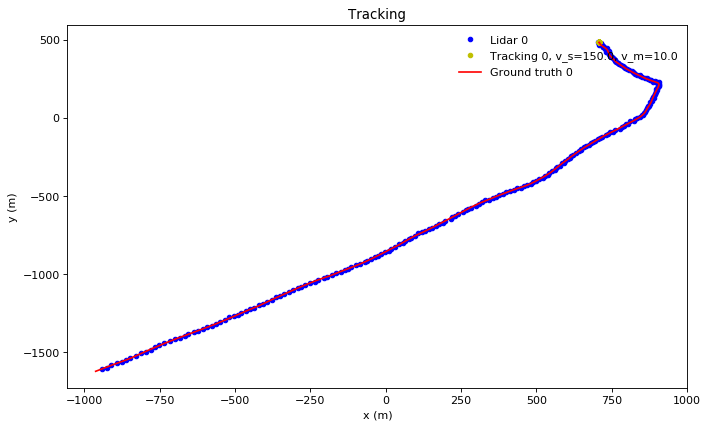

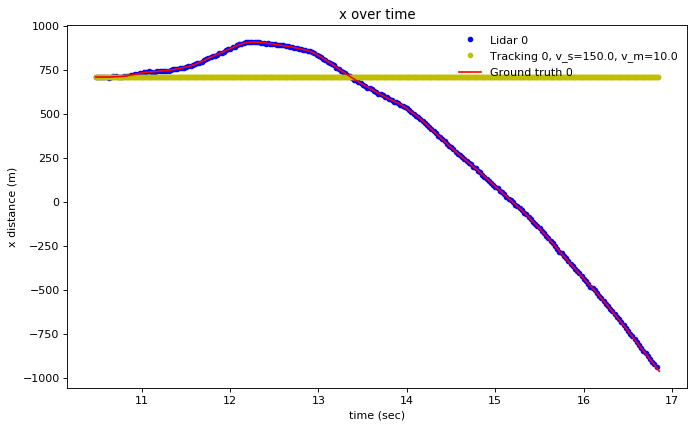

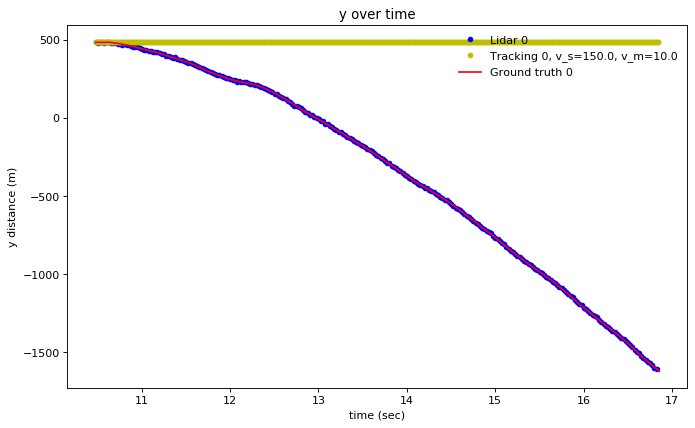

In [44]:
# Tracking plot
plt.figure(figsize=(10,6), dpi=80)
plt.title("Tracking")
lidars[objectID].plot (objectID, TRAJECTORY)
trackForPlot.plot (objectID, TRAJECTORY, COLOR['yellow'])
objects[objectID].plot (objectID, TRAJECTORY, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
lidars[objectID].plot (objectID, X)
trackForPlot.plot (objectID, X, COLOR['yellow'])
objects[objectID].plot (objectID, X, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
lidars[objectID].plot (objectID, Y)
trackForPlot.plot (objectID, Y, COLOR['yellow'])
objects[objectID].plot (objectID, Y, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()

In [29]:
# print ("Input track number: ")
objectID = int(input())

times = np.linspace (startTime_Sec, endTime_Sec, int ((endTime_Sec/dtObject)))

# varPx = np.zeros (len (timesTracking))
# varPy = np.zeros (len (timesTracking))
# varVx = np.zeros (len (timesTracking))
# varVy = np.zeros (len (timesTracking))
# varAx = np.zeros (len (timesTracking))
# varAy = np.zeros (len (timesTracking))

tracks = []

RadarIdx = 1
trackingIdx = 1

for t_Idx, t in enumerate (times):
    currTime = t
    nextTime = t + dtObject
    
#     print ('object time:', t)
    
    if (objects[objectID].startTime > currTime) and (objects[objectID].startTime <= nextTime):
#         print ('track initialized time:', objects[objectID].startTime)

        # track initialize
        track = Tracking(objectID, CV, radars[objectID].measurements[0], RADAR, objects[objectID].startTime)
        tracks.append (track)
        
    if (objects[objectID].endTime > currTime) and (objects[objectID].endTime <= nextTime):
#         print ('track terminated time:', objects[objectID].endTime)
        
        # track terminate
        trackForPlot = tracks[0]
        del tracks[objectID]
    
    if tracks:
        for trackIdx, track in enumerate (tracks):

            if track.isFirstTime:
#                 print ("track first time:", t)
                track.isFirstTime = False
                continue
            else:
                predictTime = track.prevTime + dtTracking
                updateTime = radars[objectID].times[RadarIdx]
                
                if (updateTime > currTime) and (updateTime <= nextTime):
#                     print ("update and predict time:", updateTime)
                    dt = updateTime - track.prevTime
                    z = radars[objectID].measurements[RadarIdx]
                    track.filter.predict(dt)
                    track.filter.updateEKF(z)
                    
                    track.prevTime = updateTime
                    track.times.append (updateTime)
                    track.states.append (track.filter.x)
                    track.trajectory.x.append (track.filter.x[0, 0])
                    track.trajectory.y.append (track.filter.x[1, 0])
                    
                    RadarIdx = RadarIdx + 1
                    if RadarIdx == len (radars[objectID].times):
                        RadarIdx = len (radars[objectID].times) - 1
                    
                elif (predictTime > currTime and predictTime <= nextTime):
#                     print ("predict time:", predictTime)
                    dt = predictTime - track.prevTime
                    track.filter.predict(dt)
                    
                    track.prevTime = predictTime
                    track.times.append (predictTime)
                    track.states.append (track.filter.x)
                    track.trajectory.x.append (track.filter.x[0, 0])
                    track.trajectory.y.append (track.filter.x[1, 0])
#                 if (predictTime > currTime and predictTime <= nextTime):
#                     print ("prediction time:", predictTime)
            
#                     dt = predictTime - track.prevTime
#                     track.filter.predict(dt)
                    
#                     track.prevTime = predictTime
#                     track.times.append (predictTime)
#                     track.states.append (track.filter.x)
#                     track.trajectory.x.append (track.filter.x[0, 0])
#                     track.trajectory.y.append (track.filter.x[1, 0])

0


In [30]:
# # Tracking plot
# plt.figure(figsize=(10,6), dpi=80)
# plt.title("Covariance")
# plt.plot (timesTracking, varPx, label='variance Px')
# plt.plot (timesTracking, varPy, label='variance Py')
# plt.plot (timesTracking, varVx, label='variance Vx')
# plt.plot (timesTracking, varVy, label='variance Vy')
# # plt.plot (timesTracking, varAx, label='variance Ax')
# # plt.plot (timesTracking, varAy, label='variance Ay')

# plt.legend(loc='upper right', frameon=False)
# plt.xlabel('time (sec)')
# plt.ylabel('Variance')

# plt.show()

## Plot comparing Radar Tracking with Radar measurement and Ground truth

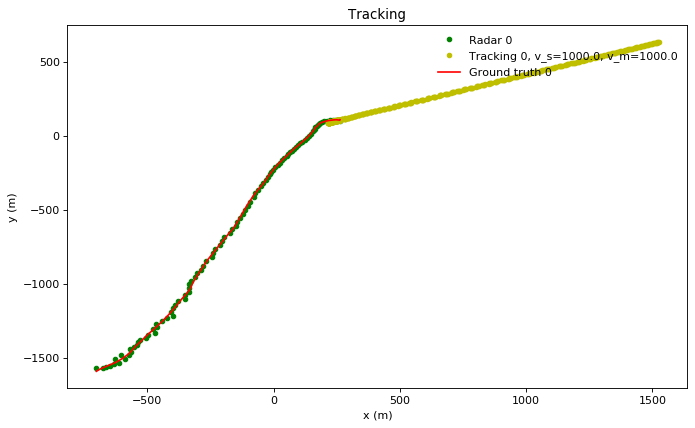

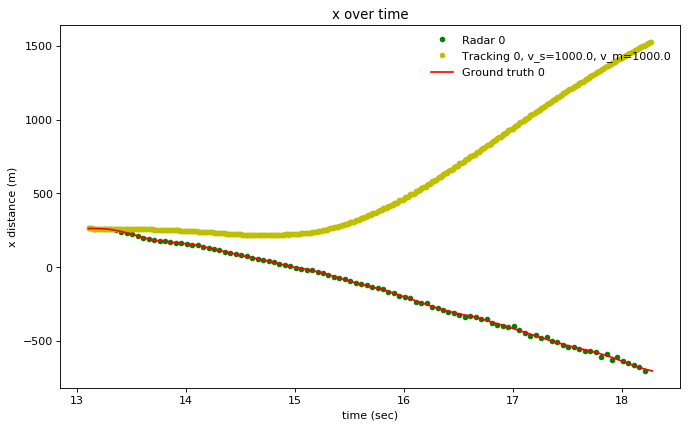

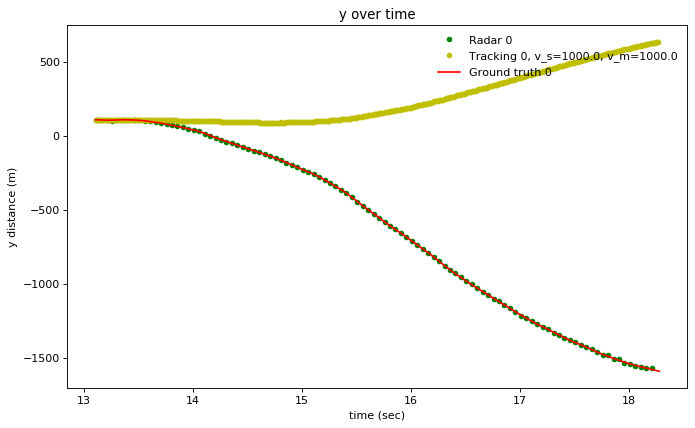

In [31]:
# Tracking plot
plt.figure(figsize=(10,6), dpi=80)
plt.title("Tracking")
radars[objectID].plot (objectID, TRAJECTORY)
trackForPlot.plot (objectID, TRAJECTORY, COLOR['yellow'])
objects[objectID].plot (objectID, TRAJECTORY, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
radars[objectID].plot (objectID, X)
trackForPlot.plot (objectID, X, COLOR['yellow'])
objects[objectID].plot (objectID, X, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
radars[objectID].plot (objectID, Y)
trackForPlot.plot (objectID, Y, COLOR['yellow'])
objects[objectID].plot (objectID, Y, COLOR['red'])

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()